In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import mplhep as hep
from scipy.optimize import curve_fit
from scipy import optimize
import pandas as pd
import uproot as ur
import statistics
import k3d
import numpy as np
import awkward as ak
import matplotlib.colors as mcolors
from scipy.stats import norm
import mplhep as hep
import hist
from hist import Hist
from iminuit import Minuit, cost
from iminuit.cost import LeastSquares
from matplotlib.ticker import ScalarFormatter
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
from sympy import Point3D, Line3D, Plane
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.patches as patches
import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl
import mplhep as hep
hep.style.use("CMS")

plt.rcParams["figure.figsize"] = (10, 8)
plt.rcParams["legend.fontsize"] = 16

In [2]:
#Reading in the ptrig data frame
cosmicDF = pd.read_pickle(r'./COSMIC_LG30_HG50_4k_R30.pkl')

In [3]:
#print(cosmicDF)
timestamps = cosmicDF["TimeStamps"]

In [4]:
cosmic = np.array(getattr(cosmicDF,"Ch_{}_LG".format("{:02d}".format(0))))
print(cosmic)
print(len(cosmic))

[79. 87. 75. ... 58. 66. 58.]
8659


In [5]:
HG_Cosmics = []

for i in range(27):
    cosmic = np.array(getattr(cosmicDF,"Ch_{}_HG".format("{:02d}".format(i))))
    HG_Cosmics.append(cosmic)
    
print(HG_Cosmics)
print(len(HG_Cosmics))

[array([68., 67., 96., ..., 57., 43., 70.]), array([ 70., 581.,  84., ...,  50., 381.,  69.]), array([ 67.,  64.,  82., ..., 404.,  55.,  66.]), array([65., 70., 94., ..., 65., 66., 68.]), array([49., 64., 54., ..., 49., 59., 66.]), array([ 68.,  60., 107., ...,  54.,  70.,  62.]), array([ 61.,  63., 734., ...,  61.,  59.,  57.]), array([67., 65., 78., ..., 57., 69., 71.]), array([ 559.,   61.,   86., ...,  644.,   70., 1079.]), array([56., 59., 78., ..., 55., 59., 63.]), array([ 81., 572.,  78., ...,  59.,  59.,  57.]), array([69., 62., 51., ..., 53., 64., 64.]), array([  80.,   66., 3102., ...,   66.,   54.,   68.]), array([ 72.,  71.,  82., ...,  54., 426.,  49.]), array([71., 68., 80., ..., 66., 55., 68.]), array([64., 58., 74., ..., 57., 54., 57.]), array([767.,  56.,  81., ..., 291.,  62., 538.]), array([ 61.,  82.,  70., ..., 284.,  56.,  62.]), array([ 67.,  69., 652., ...,  54.,  63.,  78.]), array([69., 60., 81., ..., 54., 56., 60.]), array([ 67.,  66.,  90., ...,  52.,  66.,

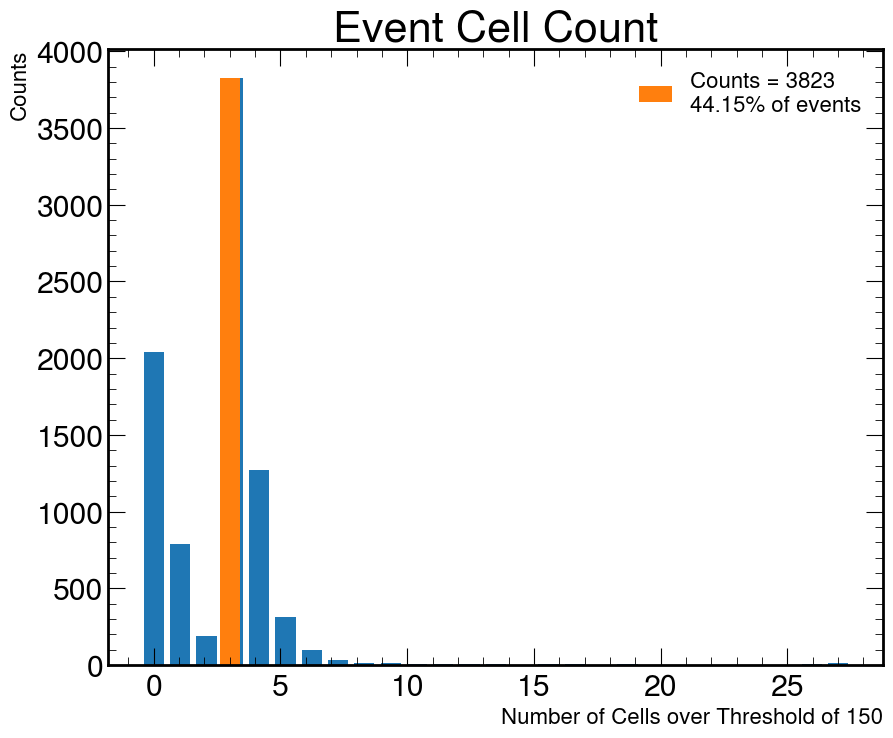

In [6]:
array_length = []
events = []
for j in range(len(cosmic)):
    cell_list = []
    for i, cosmic in enumerate(HG_Cosmics):
        if cosmic[j] > 100:
            cell_list.append(i)
    array_length.append(len(cell_list))
    events.append(cell_list)

#print(events)
hist, bin_edges = np.histogram(array_length, range=(0,27), bins=27)
x = np.linspace(0, 27, 27)

counts_dict = {}

for i, count in enumerate(hist):
    counts_dict[i] = count

highlighted_bin = 3
plt.bar(x, hist)
plt.bar(highlighted_bin, hist[highlighted_bin], label=f'Counts = {counts_dict[highlighted_bin]} \n\
{"{:.2f}".format(100*counts_dict[highlighted_bin]/len(cosmic))}% of events')

plt.xlabel('Number of Cells over Threshold of 150', fontsize=16)
plt.ylabel('Counts', fontsize=16)
plt.title('Event Cell Count')

plt.legend()
plt.show()

In [7]:
true_events = []
for cell_list in events:
    if len(cell_list) == 3:
        true_events.append(cell_list)

layer_1 = lambda x: 0 <= x <= 8
layer_2 = lambda x: 9 <= x <= 17
layer_3 = lambda x: 18 <= x <= 26

# Use a list comprehension to filter the arrays
cosmic_events = [arr for arr in true_events if layer_1(arr[0]) and layer_2(arr[1]) and layer_3(arr[2])]

print(len(cosmic_events), 'events')
print("{:.2f}".format(100*len(cosmic_events)/len(cosmic)), '% of total events')

2734 events
31.57 % of total events


C:\Users\peter\AppData\Local\Temp\ipykernel_24412\2825473663.py:195: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 10


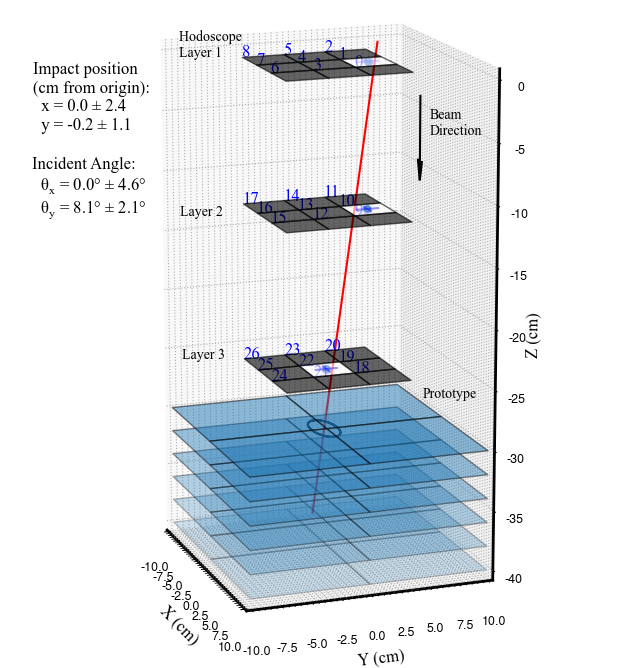

In [8]:
#Defining a 3D Figure to Display the Muon Trajectory
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

planes = [] # Define the vertices and faces for three square planes, each containing a 3x3 grid of squares
fit = [] #Defining the initial fit line through the centers of the cells
cell_number = 27
spacing = 3.5  # This is in centimeters. This is approximately the width of the scintillating tiles. 
z_pro = -30 # This is the z position of the prototype. Ideally, it goes behind the Hodoscope. 
# Create a loop to generate and position the Hodoscope squares
for z in [-25, -12, 0]:
    for y in range(-1, 2):
        for x in range(-1, 2):
            cell_number -= 1 # Indexing backwards from 27 - 0 since the loop starts at the bottom, z = -25. 
            # Define vertices for a single square centered at the origin
            square_vertices = [
                ((x - 0.5) * spacing, (y - 0.5) * spacing, z),
                ((x + 0.5) * spacing, (y - 0.5) * spacing, z),
                ((x + 0.5) * spacing, (y + 0.5) * spacing, z),
                ((x - 0.5) * spacing, (y + 0.5) * spacing, z),
            ]
            # Create Poly3DCollection for the square.
            square = Poly3DCollection([square_vertices], alpha=0.6)
            # Highlighting the squares that receive impacts. Using the Data events defined in sections above.
            if cell_number in cosmic_events[1]:
                square.set_facecolor('white')
                # Mapping the center of the squares to the fit array so that we have a set of points to fit to.
                point = (3.5)*x, (3.5)*y, z
                fit.append(point)
            else:
                square.set_facecolor('k')
            # Set edge color for the square (black color)
            square.set_edgecolor('k')
            # Add the square to the plot
            ax.add_collection3d(square)
            # Adding text to define cell number in the graph
            ax.text((x - 0.5) * spacing, (y - 0.5) * spacing, z, str(cell_number), fontsize = 12, font="Times New Roman", color='blue')

#Creating a loop to generate prototype and its layers. 
for i in np.linspace(0, 10, 6):
    # j function is to make the squares gradually fade out as they decrease in z.
    j = 0.03*i
    prototype1 = Poly3DCollection([[(-10, 10, z_pro-i), (-10, 0, z_pro-i), (0, 0, z_pro-i), (0, 10, z_pro-i)]], alpha=0.5-j)
    prototype1.set_edgecolor('k')
    ax.add_collection3d(prototype1)
    prototype2 = Poly3DCollection([[(10, 10, z_pro-i), (0, 10, z_pro-i), (0, 0, z_pro-i), (10, 0, z_pro-i)]], alpha=0.5-j)
    prototype2.set_edgecolor('k')
    ax.add_collection3d(prototype2)   
    prototype3 = Poly3DCollection([[(-10, -10, z_pro-i), (-10, 0, z_pro-i), (0, 0, z_pro-i), (0, -10, z_pro-i)]], alpha=0.5-j)
    prototype3.set_edgecolor('k')
    ax.add_collection3d(prototype3)          
    prototype4 = Poly3DCollection([[(10, -10, z_pro-i), (0, -10, z_pro-i), (0, 0, z_pro-i), (10, 0, z_pro-i)]], alpha=0.5-j)
    prototype4.set_edgecolor('k')
    ax.add_collection3d(prototype4)

# Defining the beam direction to be in the negative z direction. 
ax.quiver(0, 8, -3, 0, 0, -7, color='k', arrow_length_ratio=0.25)

# Defining our set of points to fit to. 
x = np.array([fit[0][0], fit[1][0], fit[2][0]])
y = np.array([fit[0][1], fit[1][1], fit[2][1]])
z = np.array([fit[0][2], fit[1][2], fit[2][2]])
#Defining the error of our cells. The error is approximately 3.5cm/sqrt(12) ~= 1cm. 
x_errors = np.array([1, 1, 1])
y_errors = np.array([1, 1, 1])
# Connect these points to a data set
data = np.concatenate((x[:, np.newaxis], 
                       y[:, np.newaxis], 
                       z[:, np.newaxis]), 
                      axis=1)
# Calculate the mean of the points
datamean = data.mean(axis=0)
# Do an SVD on the mean-centered data.
uu, dd, vv = np.linalg.svd(data - datamean)
# Now vv[0] contains the first principal component, i.e. the direction vector of the 'best fit' line.
# Define the line
linepts = vv[0] * np.mgrid[-25:14:3j][:, np.newaxis]
# shift by the mean to get the line in the right place
linepts += datamean
#print(linepts)
# Calculate the intersection point of the prototype surface and the HEP track.
prototype = Plane(Point3D(10, 10, z_pro), (-10, 10, z_pro), (-10, -10, z_pro))
line = Line3D(Point3D(linepts[0]), Point3D(linepts[-1]))
inter=prototype.intersection(line)

# Convert the intersection point to decimal form so we can print it cleanly
decimal_inter = [point.evalf() for point in inter]
#print("{:.2f}".format(decimal_inter[0][0]), "{:.2f}".format(decimal_inter[0][1]), "{:.2f}".format(decimal_inter[0][2]))

#NOW WE FIT THE POINTS TO A LINE IN X AND Y DIRECTIONS

#FOR X:
# Check if all x positions are the same
if np.all(x == x[0]):
    m_x_fit = 0.0
    m_x_error = 0.081
    b_x_fit = np.inf
else:
    # Define the linear model z = m_x * x + b
    def linear_model_x(x, m_x, b):
        return m_x * x + b

    # Define the chi-square function to minimize for the x-direction
    def chi_square_x(m_x, b):
        model_values = linear_model_x(linepts[:, 2], m_x, b)
        residuals = (model_values - linepts[:, 0]) / x_errors
        return np.sum(residuals**2)

    m_x = Minuit(chi_square_x, m_x=1.0, b=0.0) # Initialize Minuit and set parameters to fit for the x-direction
    m_x.migrad() # Perform the fit for the x-direction
    # Get the results for the x-direction
    m_x_fit = m_x.values['m_x']
    m_x_error = m_x.errors['m_x']
    b_x_fit = m_x.values['b']

#FOR Y:
# Check if all y positions are the same
if np.all(y == y[0]):
    m_y_fit = 0.0
    m_y_error = 0.081
    b_y_fit = np.inf
else:
    # Define the linear model z = m_y * y + b
    def linear_model_y(y, m_y, b):
        return m_y * y + b

    # Define the chi-square function to minimize for the y-direction
    def chi_square_y(m_y, b):
        model_values = linear_model_y(linepts[:, 2], m_y, b)
        residuals = (model_values - linepts[:, 1]) / y_errors
        return np.sum(residuals**2)
    
    m_y = Minuit(chi_square_y, m_y=1.0, b=0.0) # Initialize Minuit and set parameters to fit for the y-direction
    m_y.migrad() # Perform the fit for the y-direction
    # Get the results for the y-direction
    m_y_fit = m_y.values['m_y'] 
    m_y_error = m_y.errors['m_y']
    b_y_fit = m_y.values['b']

#Calculate the error of the impact position on the prototype surface using the slope error and the z position.
impact_error_y = m_y_error*z_pro
impact_error_x = m_x_error*z_pro

#CALCULATING THE ANGLE OF IMPACT IN X AND Y DIRECTION

# Define the vector normal to the surface of the prototype
normal_vector = np.array([0,0,1])

# FOR y-direction
HEP_vector_x = np.array([linepts[2][0], 0, linepts[2][2]]) - np.array([linepts[0][0], 0, linepts[0][2]])
x_angle_rad = np.arccos(np.dot(normal_vector, HEP_vector_x) / (np.linalg.norm(HEP_vector_x) * np.linalg.norm(normal_vector)))
x_angle_deg = np.degrees(x_angle_rad)
#print(x_angle_deg)

# For y-direction
HEP_vector_y = np.array([0, linepts[2][1], linepts[2][2]]) - np.array([0, linepts[0][1], linepts[0][2]])
y_angle_rad = np.arccos(np.dot(normal_vector, HEP_vector_y) / (np.linalg.norm(HEP_vector_y) * np.linalg.norm(normal_vector)))
y_angle_deg = np.degrees(y_angle_rad)
#print(y_angle_deg)

#Calculating the error on the angles using the inverse tangent of the slope error.
angle_y_error = np.degrees(np.arctan(m_y_error))
angle_x_error = np.degrees(np.arctan(m_x_error))

#The following prints are sanity checks prior to displaying the graph. 
#print(f"{angle_y_error:.2f}, {angle_x_error:.2f}")
#print(b_y_fit, b_x_fit)
#print(f"Slope (m_x): {m_x_fit:.2f} +/- {m_x_error:.2f}")
#print(f"Slope (m_y): {m_y_fit:.2f} +/- {m_y_error:.2f}")
#print(f"{decimal_inter[0][0]:.2f} ± {np.abs(impact_error_x):.2f}")
#print(f"{decimal_inter[0][1]:.2f} ± {np.abs(impact_error_y):.2f}")

# Displaying the plot of the line and the data points. 
ax.scatter3D(*data.T)
ax.errorbar(x, y, z, xerr = x_errors, yerr = y_errors, fmt="o", color="blue", alpha=0.4)
ax.plot3D(*linepts.T, color='red')

# Creating a region of error on the prototype surface. This will come out to be an ellipse shape. 
a=impact_error_x     #radius on the x-axis
b=impact_error_y   #radius on the y-axis
t = np.linspace(-2*np.pi, 2*np.pi, 100)
oval_x, oval_y, oval_z = decimal_inter[0][0]+a*np.cos(t) , decimal_inter[0][1]+b*np.sin(t), z_pro
ax.plot(oval_x, oval_y, oval_z, color='k')

ax.set_xlabel('X (cm)', fontsize = 12, font="Times New Roman") # Set axis labels
ax.set_ylabel('Y (cm)', fontsize = 12, font="Times New Roman")
ax.set_zlabel('Z (cm)', fontsize = 12, font="Times New Roman")
ax.tick_params(axis='both', labelsize=9)

ax.set_xlim(-10, 10) # Set axes limits
ax.set_ylim(-10, 10)
ax.set_zlim(-40, 0)

ax.view_init(elev=15, azim=-20) # Set initial elevation and azimuth angles
ax.dist = 10

ax.set_aspect('equal') # Set the axes dimensions to be accurate relative to each other (otherwise it will produce a square plot)

ax.text(-7, -10, 0, f'Hodoscope \nLayer 1', fontsize=10, font="Times New Roman") # Add text annotations
ax.text(-7, -10, -13, f'Layer 2', fontsize=10, font="Times New Roman")
ax.text(-7, -10, -25, f'Layer 3', fontsize=10, font="Times New Roman")
ax.text(-4, 10, -29.5, f'Prototype', fontsize=10, font="Times New Roman")
ax.text(-3, 10, -7, f'Beam\nDirection', fontsize=10, font="Times New Roman")
# Displaying data on impact position
ax.text(0, -24, -3.5, f'Impact position\n(cm from origin):\n  x = {decimal_inter[0][0]:.1f} ± {np.abs(impact_error_x):.1f}\n\
  y = {decimal_inter[0][1]:.1f} ± {np.abs(impact_error_y):.1f}', fontsize=12, font="Times New Roman")
# Displaying data on incident angle
ax.text(0, -24.2, -10, f'Incident Angle:\n  $θ_x$ = {x_angle_deg:.1f}° ± {angle_x_error:.1f}°\
\n  $θ_y$ = {y_angle_deg:.1f}° ± {angle_y_error:.1f}°', fontsize=12, font="Times New Roman")
plt.show()

In [9]:
x_hit_dist = []
y_hit_dist = []

x_slope_dist = []
y_slope_dist = []

x_angle_dist = []
y_angle_dist = []
for i in range(len(cosmic_events)):
    planes = []
    fit = []
    cell_number = 27

    # Create a loop to generate and position squares
    for z in [-25, -12, 0]:
        for y in range(-1, 2):
            for x in range(-1, 2):
                cell_number -= 1
                
                if cell_number in cosmic_events[i]:
                    square.set_facecolor('white')
                    point = (3.5)*x, (3.5)*y, z
                    fit.append(point)
    
    # Defining our set of points to fit to. 
    x = np.array([fit[0][0], fit[1][0], fit[2][0]])
    y = np.array([fit[0][1], fit[1][1], fit[2][1]])
    z = np.array([fit[0][2], fit[1][2], fit[2][2]])
    #Defining the error of our cells. The error is approximately 3.5cm/sqrt(12) ~= 1cm. 
    x_errors = np.array([1, 1, 1])
    y_errors = np.array([1, 1, 1])
    # Connect these points to a data set
    data = np.concatenate((x[:, np.newaxis], 
                           y[:, np.newaxis], 
                           z[:, np.newaxis]), 
                          axis=1)
    # Calculate the mean of the points
    datamean = data.mean(axis=0)
    # Do an SVD on the mean-centered data.
    uu, dd, vv = np.linalg.svd(data - datamean)
    # Now vv[0] contains the first principal component, i.e. the direction vector of the 'best fit' line.
    # Define the line
    linepts = vv[0] * np.mgrid[-25:14:3j][:, np.newaxis]
    # shift by the mean to get the line in the right place
    linepts += datamean
    #print(linepts)
    # Calculate the intersection point of the prototype surface and the HEP track.
    prototype = Plane(Point3D(10, 10, z_pro), (-10, 10, z_pro), (-10, -10, z_pro))
    line = Line3D(Point3D(linepts[0]), Point3D(linepts[-1]))
    inter=prototype.intersection(line)

    # Convert the intersection point to decimal form so we can print it cleanly
    decimal_inter = [point.evalf() for point in inter]

        # Check if all x positions are the same
    if np.all(x == x[0]):
        m_x_fit = 0.0
        m_x_error = 0.081
        b_x_fit = np.inf
    else:
            # Define the linear model z = m_x * x + b
        def linear_model_x(x, m_x, b):
            return m_x * x + b

            # Define the chi-square function to minimize for the x-direction
        def chi_square_x(m_x, b):
            model_values = linear_model_x(linepts[:, 2], m_x, b)
            residuals = (model_values - linepts[:, 0]) / x_errors
            return np.sum(residuals**2)

        m_x = Minuit(chi_square_x, m_x=1.0, b=0.0)
        m_x.migrad()

        # Get the results for the x-direction
        m_x_fit = m_x.values['m_x']
        m_x_error = m_x.errors['m_x']
        b_x_fit = m_x.values['b']
    
        # Check if all y positions are the same
    if np.all(y == y[0]):
        m_y_fit = 0.0
        m_y_error = 0.081
        b_y_fit = np.inf
    else:
    # Define the linear model z = m_y * y + b
        def linear_model_y(y, m_y, b):
            return m_y * y + b

    # Define the chi-square function to minimize for the y-direction
        def chi_square_y(m_y, b):
            model_values = linear_model_y(linepts[:, 2], m_y, b)
            residuals = (model_values - linepts[:, 1]) / y_errors
            return np.sum(residuals**2)
        
        m_y = Minuit(chi_square_y, m_y=1.0, b=0.0)
        m_y.migrad()
        
        # Get the results for the y-direction
        m_y_fit = m_y.values['m_y']
        m_y_error = m_y.errors['m_y']
        b_y_fit = m_y.values['b']

    #Calculate the error of the impact position on the prototype surface using the slope error and the z position.
    impact_error_y = m_y_error*z_pro
    impact_error_x = m_x_error*z_pro

    #CALCULATING THE ANGLE OF IMPACT IN X AND Y DIRECTION

    # Define the vector normal to the surface of the prototype
    normal_vector = np.array([0,0,1])

    x_angle_deg = np.degrees(np.arctan(m_x_fit))
    y_angle_deg = np.degrees(np.arctan(m_y_fit))

    #Calculating the error on the angles using the inverse tangent of the slope error.
    angle_y_error = np.degrees(np.arctan(m_y_error))
    angle_x_error = np.degrees(np.arctan(m_x_error))
    
    x_hit_dist.append(decimal_inter[0][0])
    y_hit_dist.append(decimal_inter[0][1])
    
    x_slope_dist.append(m_x_fit)
    y_slope_dist.append(m_y_fit)
    
    x_angle_dist.append(x_angle_deg)
    y_angle_dist.append(y_angle_deg)
    
print(len(x_hit_dist))
print(len(y_hit_dist))
#print(x_angle_dist)
#print(y_angle_dist)
print("Average Incident Angle x = ", "{:.4f}".format(np.mean(x_angle_dist)))
print("Average Incident Angle y = ", "{:.4f}".format(np.mean(y_angle_dist)))

2734
2734
Average Incident Angle x =  -0.1330
Average Incident Angle y =  -0.9567


Average =  -0.1330


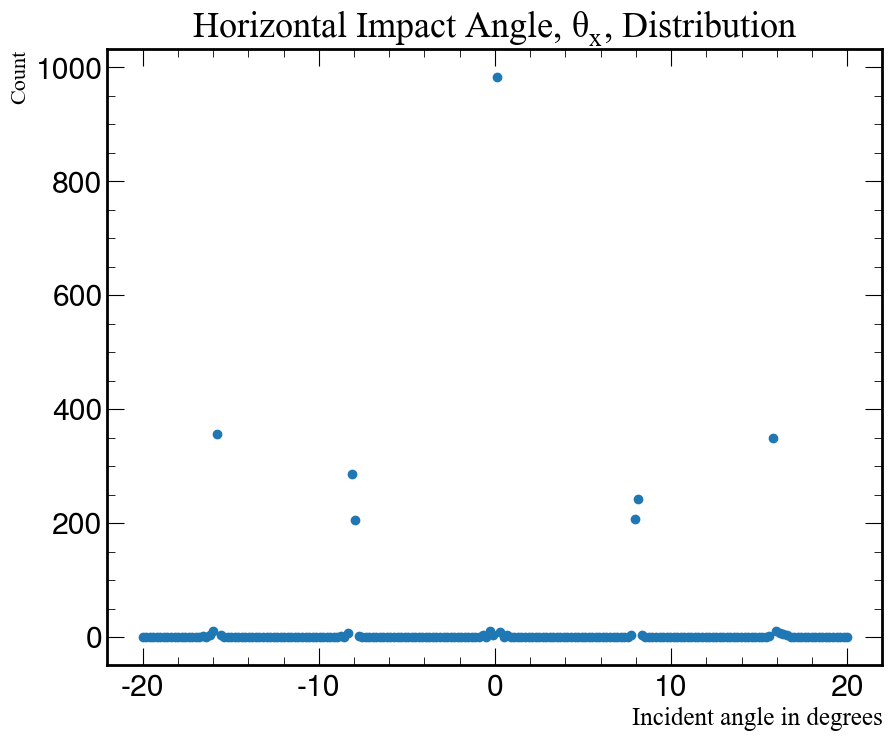

In [16]:
hist, bin_edges = np.histogram(x_angle_dist, range=(-20, 20), bins=200)
x = np.linspace(-20, 20, 200)
plt.scatter(x, hist)
plt.xlabel("Incident angle in degrees", fontsize=18, font="Times New Roman")
plt.ylabel('Count', fontsize=16, font="Times New Roman")
plt.title("Horizontal Impact Angle, $θ_x$, Distribution", fontsize=16, font="Times New Roman")
print("Average = ", "{:.4f}".format(np.mean(x_angle_dist)))

Average =  -0.9567


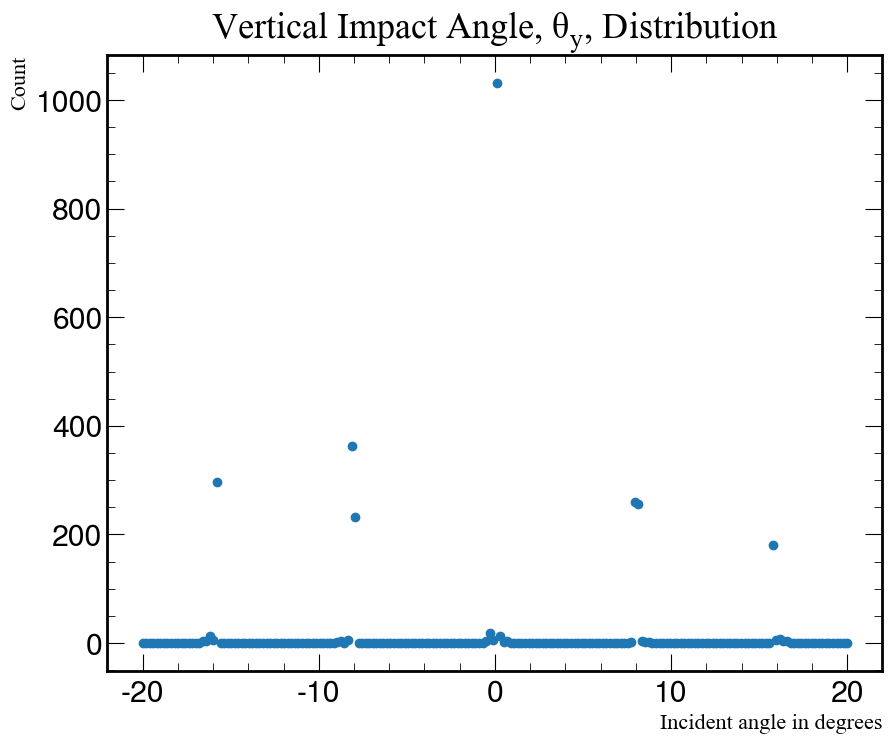

In [17]:
hist, bin_edges = np.histogram(y_angle_dist, range=(-20, 20), bins=200)
y = np.linspace(-20, 20, 200)
plt.scatter(y, hist)
plt.xlabel("Incident angle in degrees", fontsize=16, font="Times New Roman")
plt.ylabel('Count', fontsize=16, font="Times New Roman")
plt.title("Vertical Impact Angle, $θ_y$, Distribution", fontsize=18, font="Times New Roman")
print("Average = ", "{:.4f}".format(np.mean(y_angle_dist)))

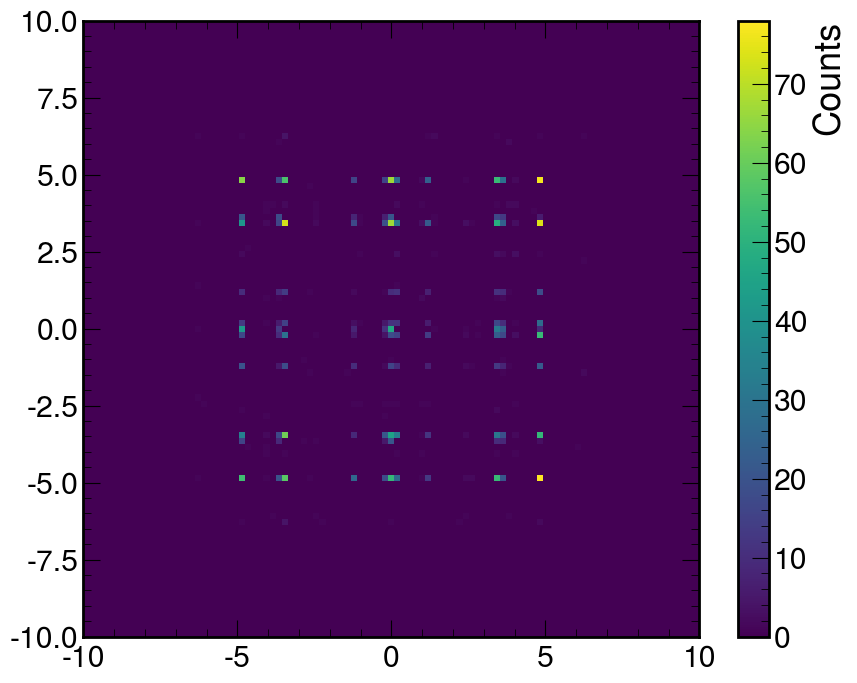

In [28]:
x_bins = np.linspace(-10,10,100)
y_bins = np.linspace(-10,10,100)
H, xedges, yedges = np.histogram2d(x_hit_dist, y_hit_dist, bins=(x_bins, y_bins))
X, Y = np.meshgrid(xedges, yedges)
#fig, ax = plt.subplots(1,1)
#ax.pcolormesh(X, Y, H)
#ax.colorbar()
im = plt.imshow(H, cmap='viridis', extent=(-10, 10, -10, 10))
plt.colorbar(im, label="Counts")

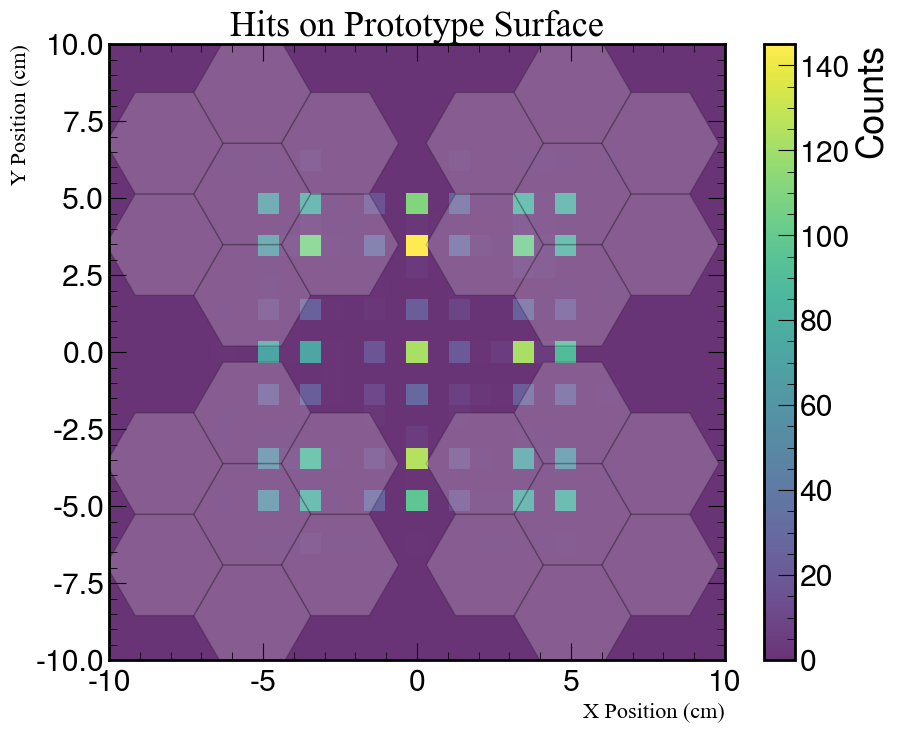

In [25]:
from matplotlib.patches import RegularPolygon

# Create a function to draw a single hexagon
def draw_hexagon(ax, x_center, y_center, size, color):
    hexagon = RegularPolygon((x_center, y_center), numVertices=6, radius=size, orientation=np.pi / 6, color=color, ec='k', alpha=0.2)
    ax.add_patch(hexagon)

# Create a figure and axis
fig, ax = plt.subplots(1, 1)

# Define the size of the hexagons and the number of rows and columns
hexagon_size = 1.9
num_rows = 3
num_cols = 3

# Calculate the horizontal and vertical spacing between hexagons
horizontal_spacing = 1.5 * hexagon_size
vertical_spacing = np.sqrt(3) * hexagon_size

# Loop through rows and columns to draw hexagons and initialize a count array
counts = np.zeros((num_rows, num_cols), dtype=int)

for row in range(num_rows):
    for col in range(num_cols):
        x_center = -8.2 + col * horizontal_spacing
        y_center = 0.2 + row * vertical_spacing
        if col % 2 == 1:
            y_center += vertical_spacing / 2  # Shift every other column up
        if col == 0 or col == 2:
            if row > 0:
                draw_hexagon(ax, x_center, y_center, hexagon_size, 'white')
        if col == 1:
            draw_hexagon(ax, x_center, y_center, hexagon_size, 'white')
            
for row in range(num_rows):
    for col in range(num_cols):
        x_center = 2.2 + col * horizontal_spacing
        y_center = 0.2 + row * vertical_spacing
        if col % 2 == 1:
            y_center += vertical_spacing / 2  # Shift every other column up
        if col == 0 or col == 2:
            if row > 0:
                draw_hexagon(ax, x_center, y_center, hexagon_size, 'white')
        if col == 1:
            draw_hexagon(ax, x_center, y_center, hexagon_size, 'white')
            
for row in range(num_rows):
    for col in range(num_cols):
        x_center = -8.2 + col * horizontal_spacing
        y_center = -10.2 + row * vertical_spacing
        if col % 2 == 1:
            y_center += vertical_spacing / 2  # Shift every other column up
        if col == 0 or col == 2:
            if row > 0:
                draw_hexagon(ax, x_center, y_center, hexagon_size, 'white')
        if col == 1:
            draw_hexagon(ax, x_center, y_center, hexagon_size, 'white')
            
for row in range(num_rows):
    for col in range(num_cols):
        x_center =  2.2 + col * horizontal_spacing
        y_center = -10.2 + row * vertical_spacing
        if col % 2 == 1:
            y_center += vertical_spacing / 2  # Shift every other column up
        if col == 0 or col == 2:
            if row > 0:
                draw_hexagon(ax, x_center, y_center, hexagon_size, 'white')
        if col == 1:
            draw_hexagon(ax, x_center, y_center, hexagon_size, 'white')

x_bins = np.linspace(-10,10,30)
y_bins = np.linspace(-10,10,30)
H, xedges, yedges = np.histogram2d(x_hit_dist, y_hit_dist, bins=(x_bins, y_bins))
X, Y = np.meshgrid(xedges, yedges)
plt.imshow(H, extent=[-10, 10, -10, 10], cmap='viridis', alpha=0.8)
plt.colorbar(label='Counts')
plt.xlabel('X Position (cm)', fontsize = 16, font="Times New Roman")
plt.ylabel('Y Position (cm)', fontsize = 16, font="Times New Roman")
plt.title('Hits on Prototype Surface', fontsize = 24, font="Times New Roman")
#plt.title('Bin size = 30', fontsize=20, font="Times New Roman")
plt.show()